In [2]:
import sys
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# To get functions to plot the band structure and hamiltonian
sys.path.append("../../../") # path to periodiclas
from periodiclas.tools.util import LASdata
sns.set()

In [3]:
# DMRG Reference values
DMRGIP = -6.39
DMRGEA = 2.54

In [4]:
dpi = 500

plt.rcParams.update({
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.labelsize': 28,
    'figure.dpi': dpi,
    'axes.grid': True,
    'grid.linestyle': '--',
    'figure.figsize':(16,10),
    'axes.titlesize':24
})

# Fig 2B

In [7]:
def get_hamiltonian(civec, energy,diag_sub=False):
    '''
    LASSI Hamiltonian
    args:
        civec:
        energy:
    return:
        hmat:
    '''
    nstates = civec.shape[0]
    hmat = np.zeros((nstates, nstates))

    for i in range(nstates):
        hmat += np.outer(civec[:,i],civec[:,i]) * energy[i]

    if diag_sub:
        hmat = hmat - np.diag(np.diag(hmat))
    else:
        # Remove the noise
        minval = -10
        for i in range(nstates):
            hmat[i][np.where(hmat[i] != 0)] = np.log10(np.abs(hmat[i][np.where(hmat[i] != 0)]))
            hmat[i][np.where(hmat[i] < minval)] = minval #minimum shown value
            hmat[i][np.where(hmat[i] == 0)] = minval #arbitrary

    return hmat


def plot_hamiltonian(hmat, figname, cmap="magma", dpi=300, fragsize=2, anotate=False):
    '''
    Plot the Hamilotnian
    '''
    nstates = hmat.shape[0]

    plt.figure(figsize=(16, 12))
    ax = sns.heatmap(hmat,
            cmap=cmap,
            cbar_kws={'label': r"$\log_{10}(|H_{ij}|)$"})

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=34)
    cbar.set_label(r"$\log_{10}(|H_{ij}|)$", fontsize=34)

    ax.tick_params(axis='x', bottom=False, top=False)
    ax.tick_params(axis='y', left=False, right=False)
    ax.set_xticks(ticks=np.arange(0, nstates, 4))
    ax.set_yticks(ticks=np.arange(0, nstates, 4))
    ax.set_xticklabels(np.arange(0, nstates, 4),
            rotation=0, ha="center", rotation_mode='anchor')
    ax.set_yticklabels(np.arange(0, nstates, 4),
            rotation=0, ha="center", rotation_mode='anchor')

    block_centers = [
            (1 + (nstates // 4), 2 + (nstates // 2)),
            (1 + (3 * nstates // 4), nstates // 2 - 0.5)]
    block_labels = ["N+1 States", "N-1 States"]

    for (x, y), label in zip(block_centers, block_labels):
        plt.text(x, y, label, fontsize=32, ha='center', va='top', color='white')

    plt.title(f'LASSI Hamiltonian: H-Chain (2,2)x(1,1,16)',fontsize=40, pad=20)
    
    ax.yaxis.set_tick_params(pad=20)
    plt.xticks(fontsize=34)
    plt.yticks(fontsize=34)
    if anotate:
        plt.annotate("B",(1, 32),c='white',size=38)
    plt.tight_layout()
    plt.savefig(figname+'ham.pdf', dpi=dpi, bbox_inches='tight')
    return plt

<module 'matplotlib.pyplot' from '/project/lgagliardi/jangidbhavnesh/Apps/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

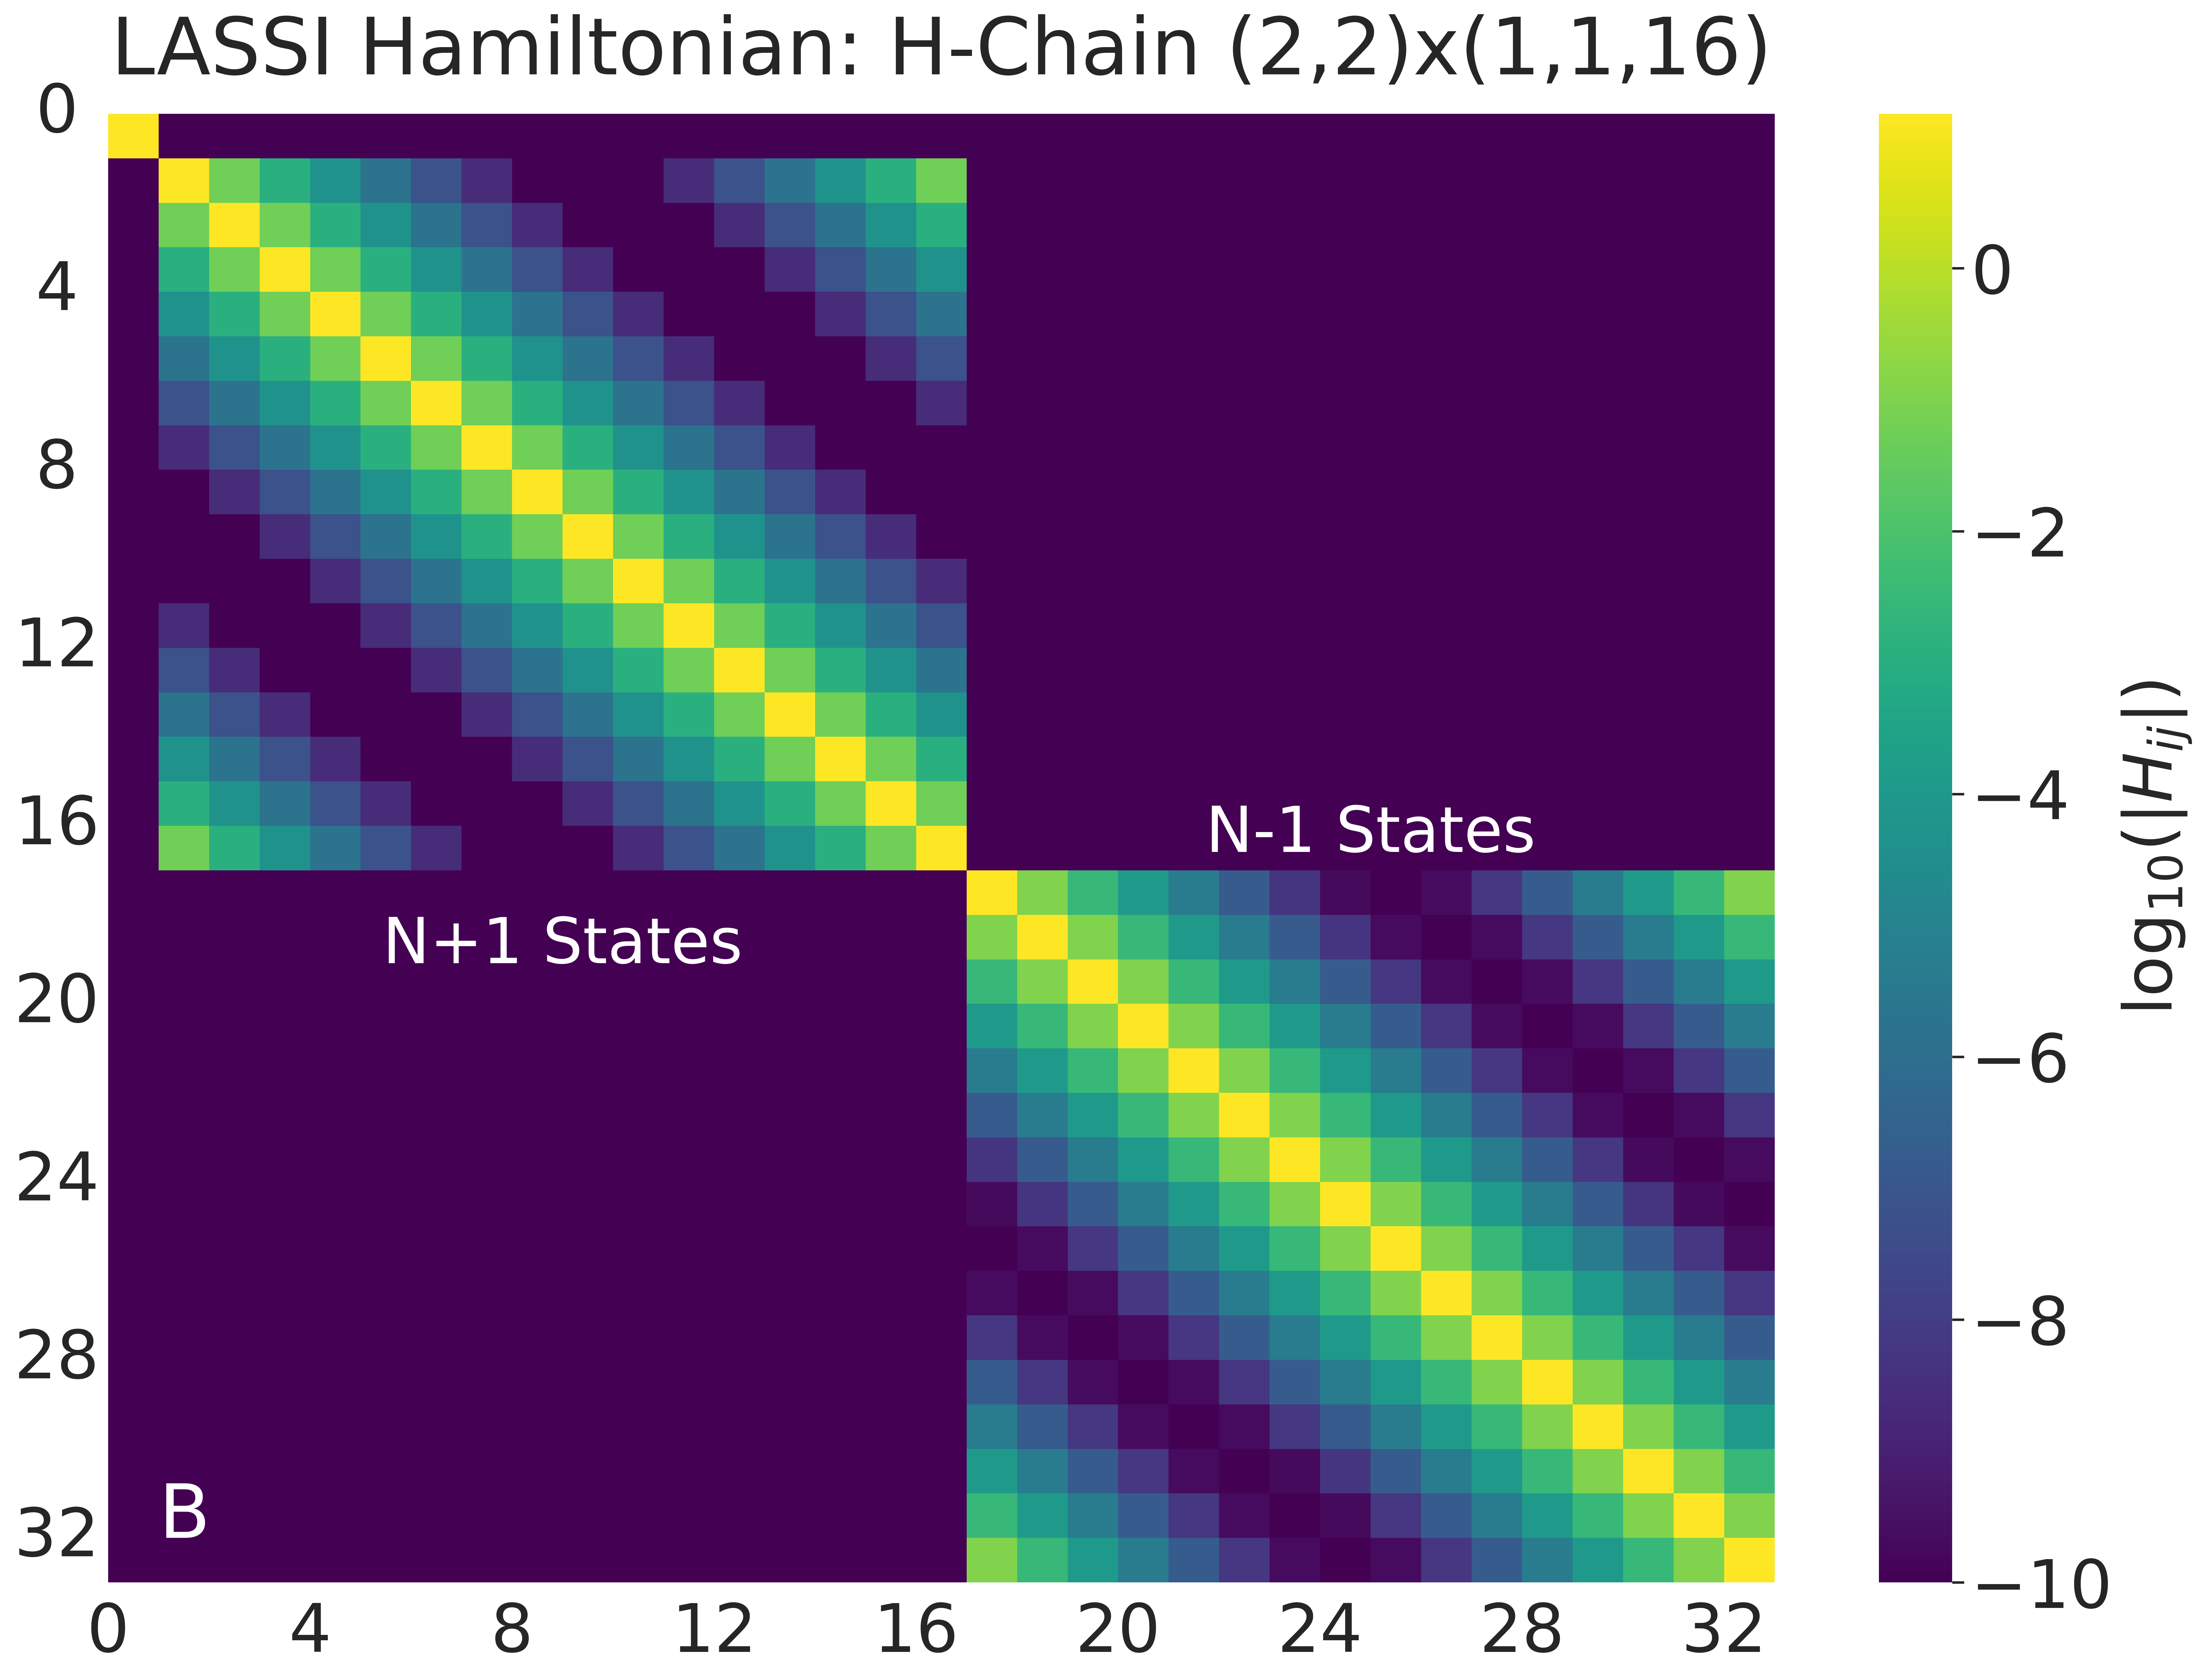

In [8]:
# Plot the Hamiltonian
pklfile = './hchain.2.32.pkl'

lasdata = LASdata(pkl_fn=pklfile, pct_pdft=0)

hmat = get_hamiltonian(lasdata.civecs, lasdata.energies_lassi)
plot_hamiltonian(hmat, 'LASHamiltonian.', cmap="viridis", dpi=dpi, fragsize=2, anotate=True)

# Fig 2C

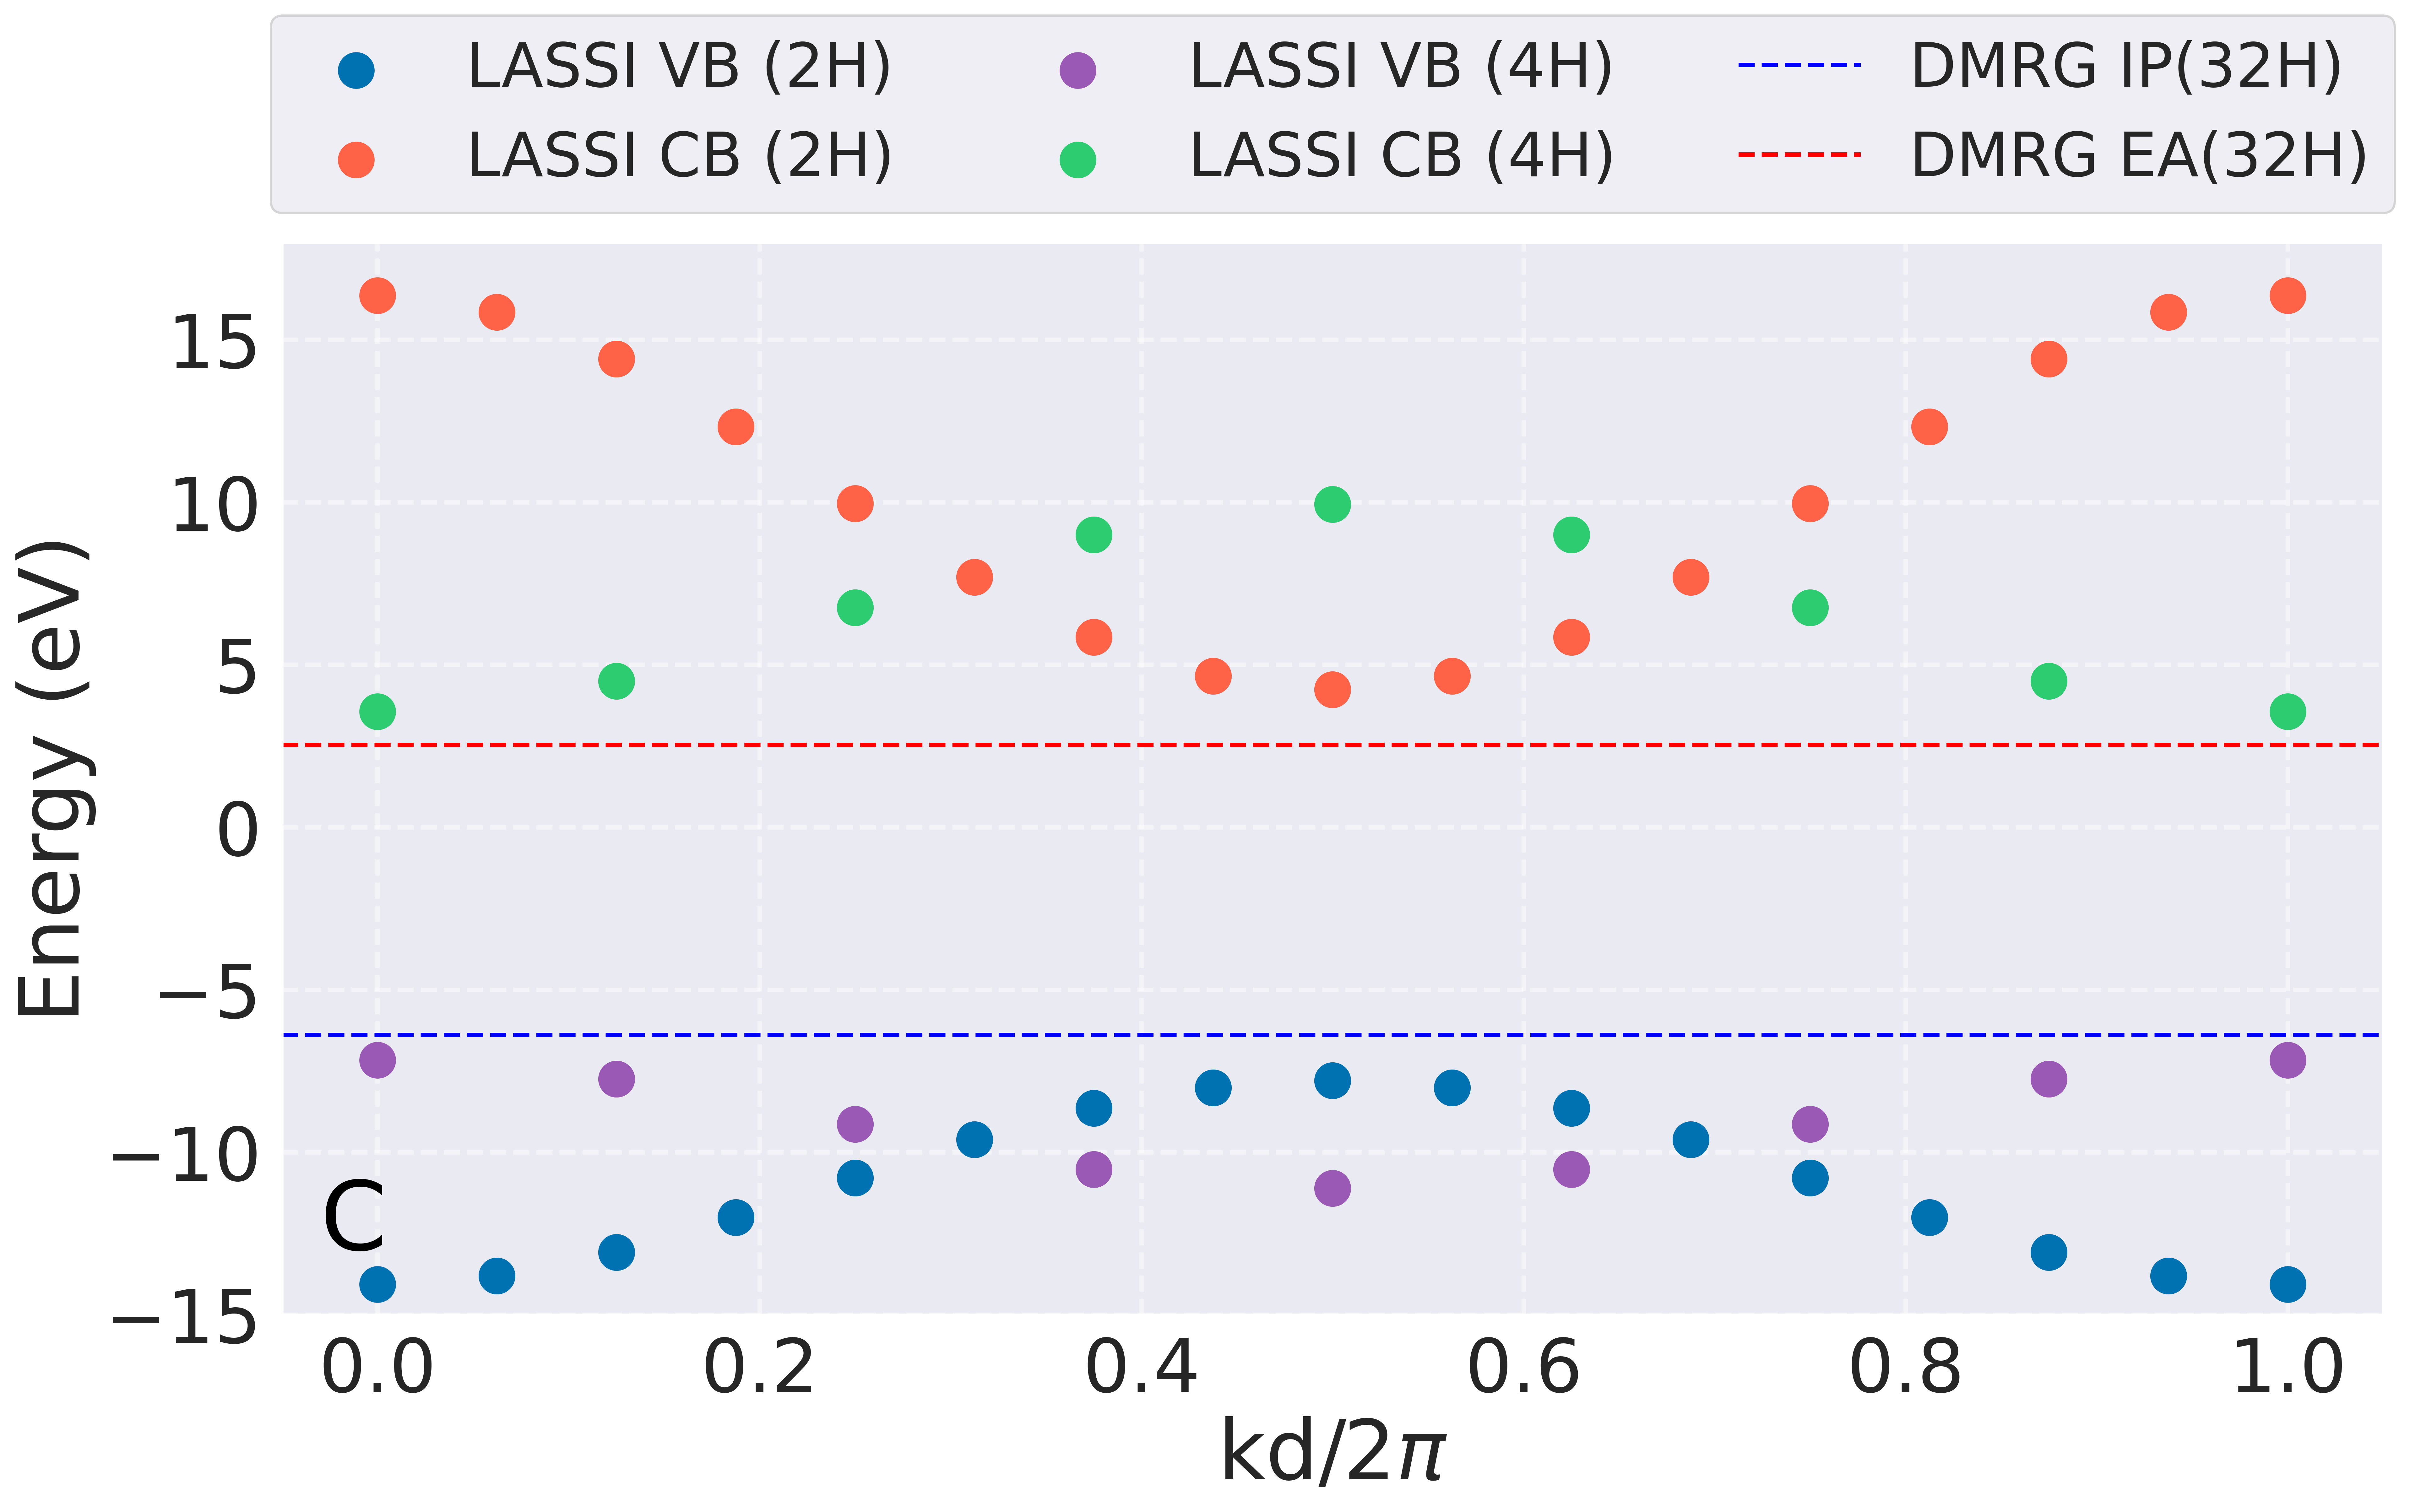

In [9]:
plt.figure()

pklfile = './hchain.2.32.pkl'
lasdata = LASdata(pkl_fn=pklfile, pct_pdft=0)
homo_e, homo_k = lasdata.get_homo()
lumo_e, lumo_k = lasdata.get_lumo()
plt.scatter(homo_k, homo_e, label="LASSI VB (2H)", color='#0072B2', marker='o',  s=250)
plt.scatter(lumo_k, lumo_e, label="LASSI CB (2H)", color='#FF6347', marker='o',  s=250)


pklfile = './hchain.4.32.pkl'
lasdata = LASdata(pkl_fn=pklfile, pct_pdft=0)
homo_e, homo_k = lasdata.get_homo()
lumo_e, lumo_k = lasdata.get_lumo()
plt.scatter(homo_k, homo_e, label="LASSI VB (4H)", color='#9B59B6', marker='o',  s=250)
plt.scatter(lumo_k, lumo_e, label="LASSI CB (4H)", color='#2ECC71', marker='o',  s=250)

plt.axhline(y=DMRGIP, color='blue', linestyle='--', linewidth=2, label='DMRG IP(32H)')
plt.axhline(y=DMRGEA, color='red', linestyle='--', linewidth=2, label='DMRG EA(32H)')

plt.xlabel("kd/2$\pi$", fontsize=38)
plt.ylabel("Energy (eV)", fontsize=38)
plt.ylim(-15, 18)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.24), ncol=3, frameon=True,  fontsize=28)
plt.grid(True, which='both', linestyle='--', linewidth=2, alpha=0.5)
plt.tight_layout()
plt.annotate("C",(-0.03,-13),c="black",size=44)
plt.savefig('LASH32ChainBandStructure.pdf', dpi=dpi)
# plt.close()

# Fig 2D

In [10]:
def get_homo_band_dft(pklfile):
    with open(pklfile, "rb") as f:
        data = pickle.load(f)
    homo_e, homo_k = data['homo_e'], data['homo_k']
    return  homo_e, homo_k

def get_lumo_band_dft(pklfile):
    with open(pklfile, "rb") as f:
        data = pickle.load(f)
    lumo_e, lumo_k = data['lumo_e'], data['lumo_k']
    return lumo_e, lumo_k

get_homo = get_homo_band_dft
get_lumo = get_lumo_band_dft

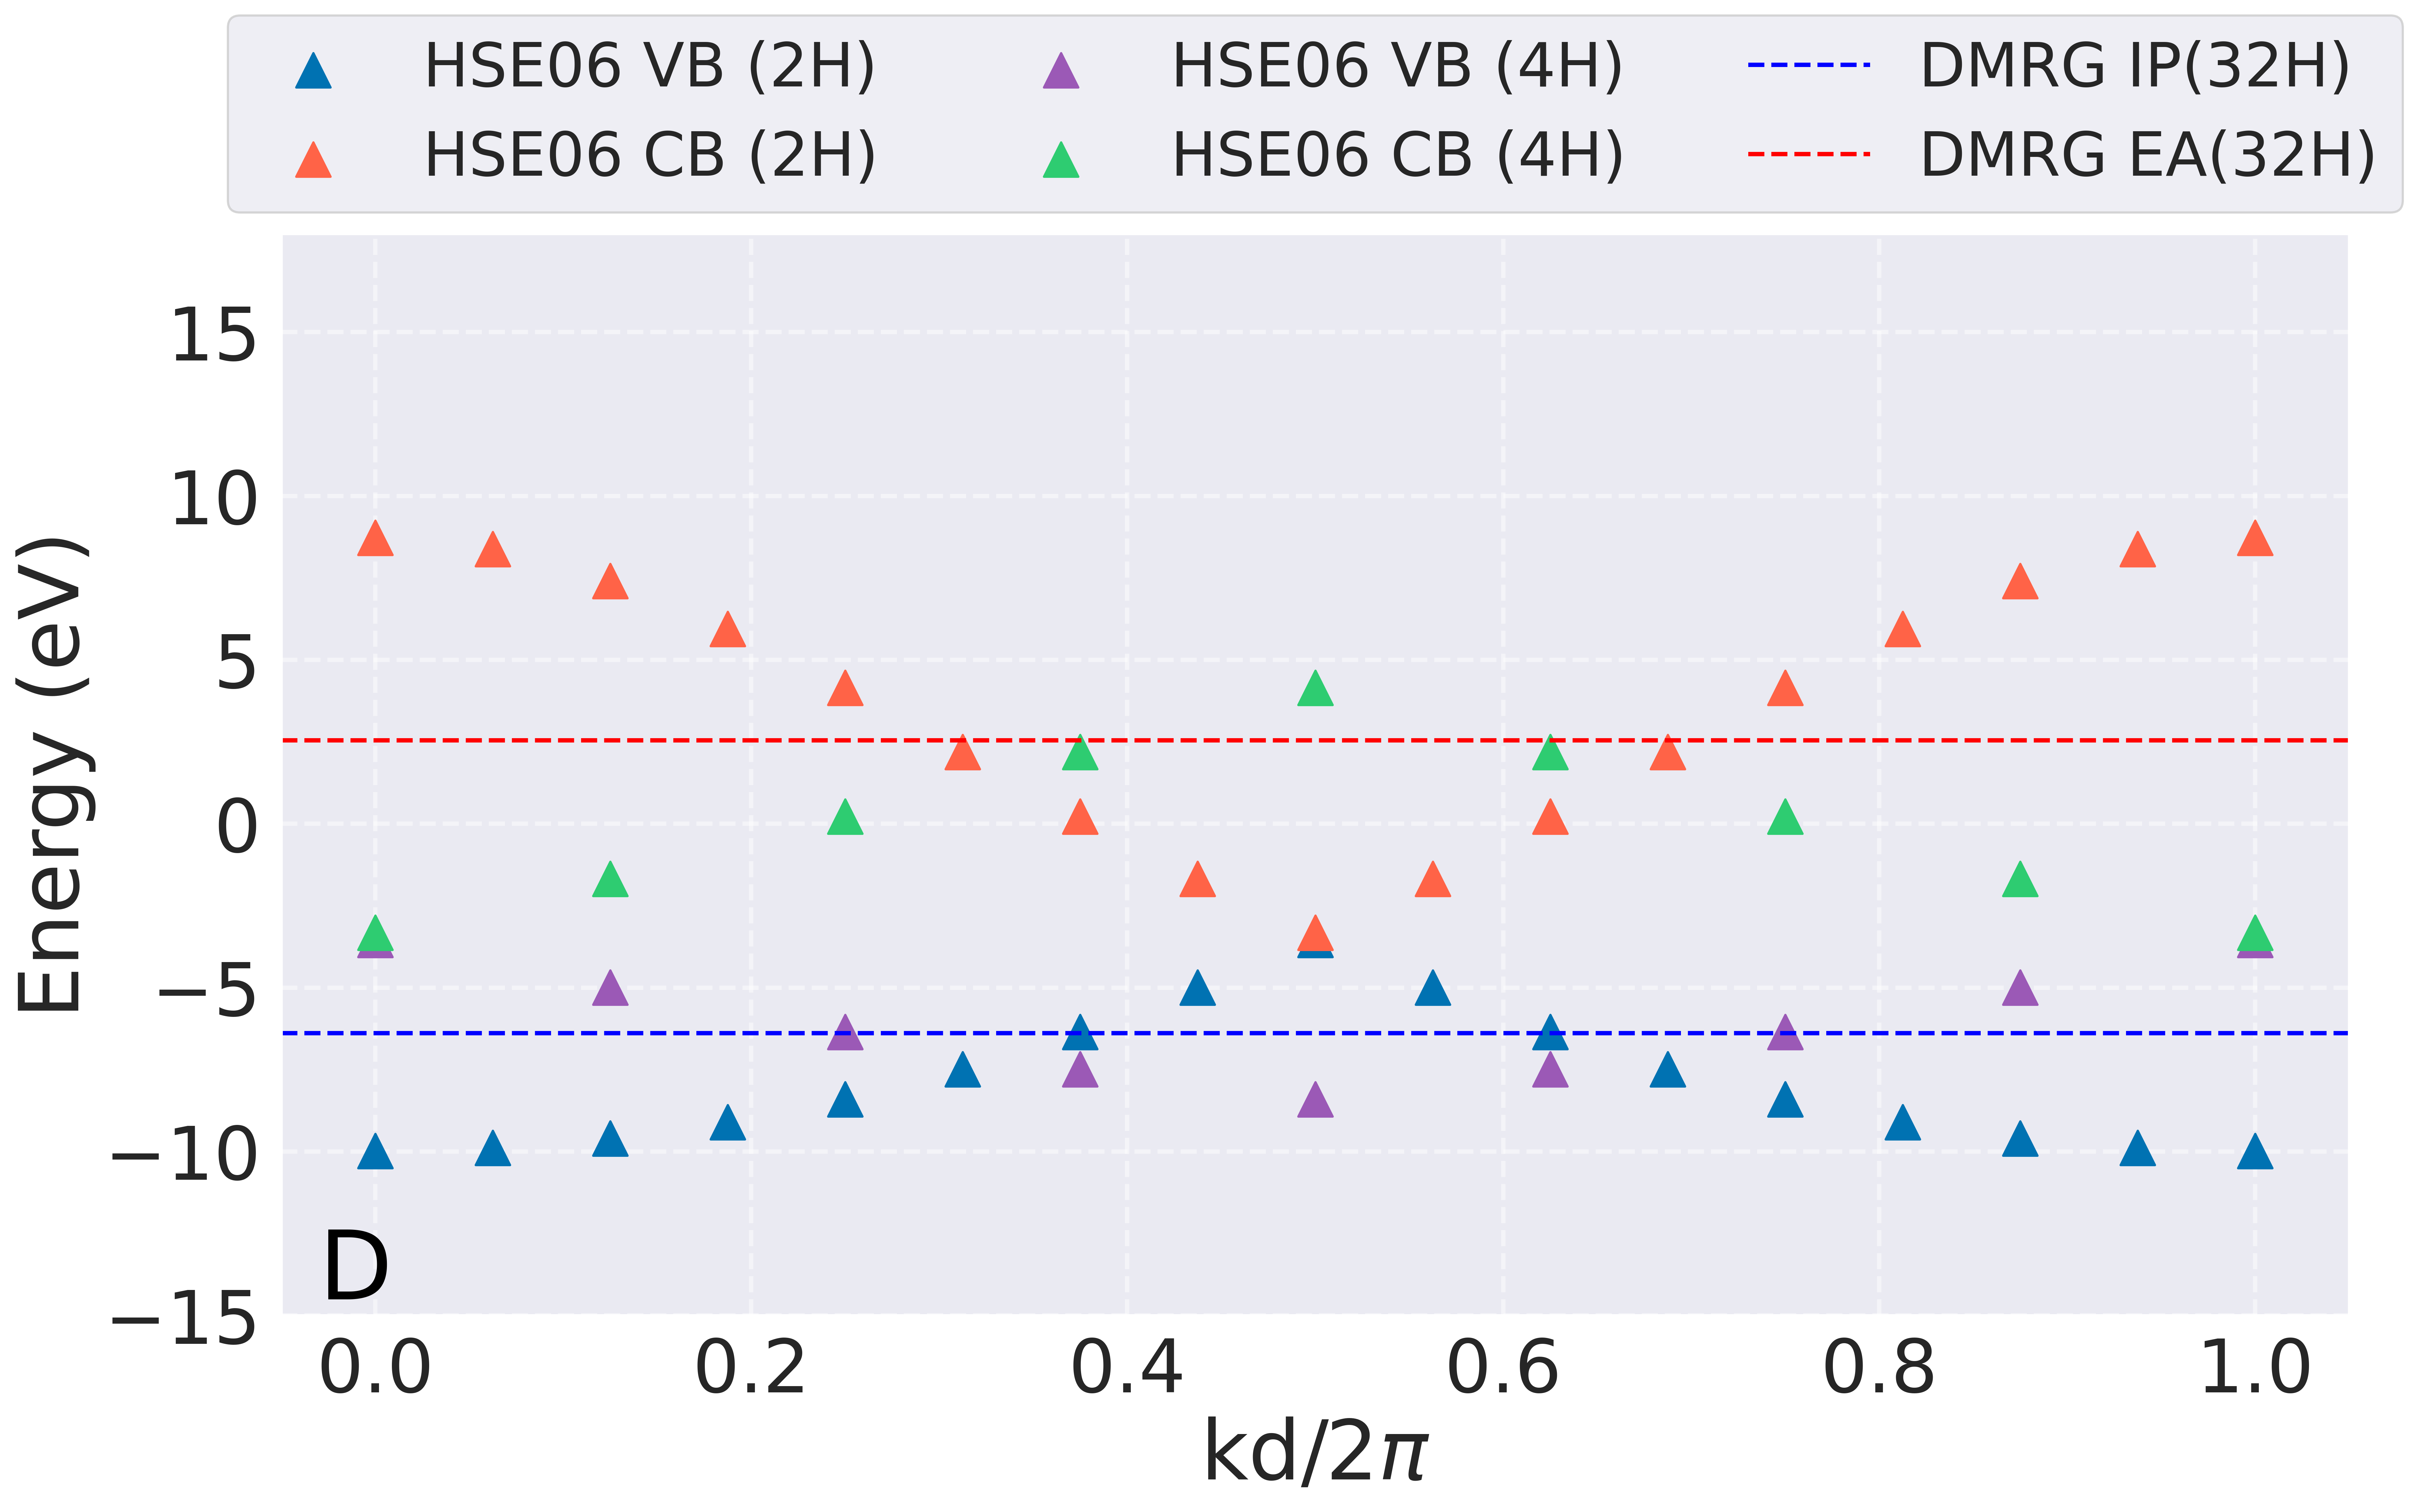

In [11]:
plt.figure()
# (2H, 16)
pklfile = './hchain.HSE06.2.16.pkl'
homo_e, homo_k = get_homo(pklfile)
lumo_e, lumo_k = get_lumo(pklfile)
plt.scatter(homo_k, homo_e, label="HSE06 VB (2H)", color='#0072B2', marker='^',  s=250)  
plt.scatter(lumo_k, lumo_e, label="HSE06 CB (2H)", color='#FF6347', marker='^',  s=250)  

# (4H, 8)
pklfile = './hchain.HSE06.4.8.pkl'
homo_e, homo_k = get_homo(pklfile)
lumo_e, lumo_k = get_lumo(pklfile)
plt.scatter(homo_k, homo_e, label="HSE06 VB (4H)", color='#9B59B6', marker='^',  s=250)  
plt.scatter(lumo_k, lumo_e, label="HSE06 CB (4H)", color='#2ECC71', marker='^',  s=250)  

# DMRG Reference Data.
plt.axhline(y=DMRGIP, color='blue', linestyle='--', linewidth=2, label='DMRG IP(32H)')
plt.axhline(y=DMRGEA, color='red',  linestyle='--', linewidth=2, label='DMRG EA(32H)')

# plt.xlabel(r"$\frac{kd}{2\pi}$", fontsize=46)
plt.xlabel("kd/2$\pi$", fontsize=38)
plt.ylabel("Energy (eV)", fontsize=38)
plt.ylim(-15, 18)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.23), ncol=3, frameon=True, fontsize=28, fancybox=True)
plt.grid(True, which='both', linestyle='--', linewidth=2, alpha=0.5)
plt.tight_layout()
plt.annotate("D",(-0.03,-14.5),c="black",size=44)
plt.savefig('HSE06_HChainBandStructure.pdf', dpi=dpi)
# plt.close()
